In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2

In [2]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [3]:
def decoder_block(inputs, skip, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip])
    x = conv_block(x, num_filters)

    return x

In [4]:
def build_mobilenetv2_unet(input_shape,num_classes):    ## (512, 512, 3)
    """ Input """
    inputs = Input(shape=input_shape)

    """ Pre-trained MobileNetV2 """
    encoder = MobileNetV2(include_top=False, weights="imagenet",
        input_tensor=inputs, alpha=1.4)

    """ Encoder """
    s1 = encoder.layers[0].output                ## (512 x 512)
    s2 = encoder.get_layer("block_1_expand_relu").output    ## (256 x 256)
    s3 = encoder.get_layer("block_3_expand_relu").output    ## (128 x 128)
    s4 = encoder.get_layer("block_6_expand_relu").output    ## (64 x 64)

    """ Bridge """
    b1 = encoder.get_layer("block_13_expand_relu").output   ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                         ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                         ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                         ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                          ## (512 x 512)

    """ Output """
    outputs = Conv2D(num_classes, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="MobileNetV2_U-Net")
    return model

In [5]:
model = build_mobilenetv2_unet((256, 256, 3),1)
model.summary()

Model: "MobileNetV2_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 48  1296        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 48  192         ['Conv1[0][0]']                  
                                )                                                 

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
drive_path = '/content/drive/MyDrive/PFA' 

# Training

In [8]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision, Accuracy, IoU
from sklearn.model_selection import train_test_split

In [9]:
H = 256
W = 256

def create_dir(path):
    """Create a directory"""
    if not os.path.exists(path):
        os.mkdir(path)

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def load_data(path):
    images = sorted(glob(f"{path}/ROI/*.bmp"))
    masks = sorted(glob(f"{path}/GT_TE/*.bmp")) #to be changed for every region
    
    print(len(masks), len(images))

    train_x, valid_x = train_test_split(images, test_size=0.2, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=0.2, random_state=42)
    print(len(train_x), len(train_y), len(valid_x), len(valid_y))
   
    return (train_x, train_y), (valid_x, valid_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode('utf-8')
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    '''
    x[x == 255] = 0
    x[x == 223] = 1 #ZP
    x[x == 127] = 2 #TE
    x[x == 191] = 3 #ICM
    x[ x > 3] = 0
    
    x = x.astype(np.int32)
    '''
    x[x!=0] =255
    x = x/255.0
    x = x > 0.5
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    #y = tf.one_hot(y, 4, dtype=tf.int32)
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])

    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)

    return dataset

# New Section

In [10]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [11]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

"""Directory for storing files"""
create_dir("/content/drive/MyDrive/PFA/files_mobilenet")

"""Hyperparameters"""
batch_size = 10
learning_rate = 1e-4
num_epochs = 70
model_path = os.path.join("/content/drive/MyDrive/PFA/files_mobilenet", "model_te.h5") #to be changed for every region
csv_path = os.path.join("/content/drive/MyDrive/PFA/files_mobilenet", "data_te.csv") #to be changed for every region

"""Dataset"""
dataset_path = os.path.join("/content/drive/MyDrive/PFA/new_data")
train_path = os.path.join(dataset_path, "train")

(train_x, train_y), (valid_x, valid_y) = load_data(train_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
test_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

"""Model"""

model = build_mobilenetv2_unet((H, W, 3),1)
metrics = [dice_coef, iou, 'accuracy', Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=Adam(learning_rate), metrics=metrics)

train_steps = len(train_x)//batch_size
valid_steps = len(valid_x)//batch_size

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False)
]

history = model.fit(
    train_dataset,
    steps_per_epoch=train_steps,
    epochs=num_epochs,
    validation_data=test_dataset,
    validation_steps=valid_steps,
    callbacks=callbacks
)

945 945
756 756 189 189
Train: 756 - 756
Valid: 189 - 189
Epoch 1/70
75/75 [==============================] - ETA: 0s - loss: 0.4272 - dice_coef: 0.5728 - iou: 0.4128 - accuracy: 0.8893 - recall: 0.9393 - precision: 0.5197
Epoch 1: val_loss improved from inf to 0.65815, saving model to /content/drive/MyDrive/PFA/files_mobilenet/model_te.h5
75/75 [==============================] - 219s 3s/step - loss: 0.4272 - dice_coef: 0.5728 - iou: 0.4128 - accuracy: 0.8893 - recall: 0.9393 - precision: 0.5197 - val_loss: 0.6581 - val_dice_coef: 0.3419 - val_iou: 0.2063 - val_accuracy: 0.7655 - val_recall: 0.9995 - val_precision: 0.3403 - lr: 1.0000e-04
Epoch 2/70
75/75 [==============================] - ETA: 0s - loss: 0.2596 - dice_coef: 0.7403 - iou: 0.5884 - accuracy: 0.9656 - recall: 0.9542 - precision: 0.7971
Epoch 2: val_loss improved from 0.65815 to 0.44277, saving model to /content/drive/MyDrive/PFA/files_mobilenet/model_te.h5
75/75 [==============================] - 52s 632ms/step - loss: 0

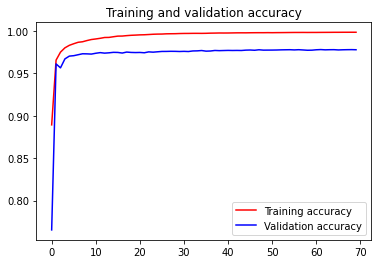

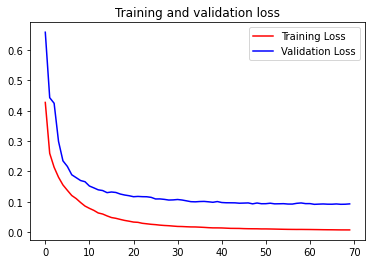

In [12]:
# Plot the chart for accuracy and loss on both training and validation
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
def load_data(path):

    images = sorted(glob(f"{path}/ROI/*.bmp"))
    masks = sorted(glob(f"{path}/GT_TE/*.bmp")) #to be changed for every region
    
    print(len(images), len(masks))
   
    return (images, masks)
    
test_path = os.path.join(dataset_path, "test")
(test_x, test_y) = load_data(test_path)

48 48


In [14]:
from tqdm import tqdm

In [15]:
num_classes = 1
res_path = os.path.join(dataset_path, "results_mobilenet_TE") #to be changed for every region
create_dir(res_path)
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
        name = x.split("/")[-1]

        ## Read image
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        x = x / 255.0
        x = x.astype(np.float32)
        
        ## Read mask
        y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        y[y == 255] = 0
        y[y == 223] = 1 #ZP
        y[y == 127] = 2 #TE
        y[y == 191] = 3 #ICM
        y[ y > 3] = 0
        y = np.expand_dims(y, axis=-1) ## (256, 256, 1)
        y = y * (255/num_classes)
        y = y.astype(np.int32)
        y = np.concatenate([y, y, y], axis=2)

        ## Prediction
        
        p = model.predict(np.expand_dims(x, axis=0))[0]
        
        p = p > 0.5
        p = p.astype(np.int32)
        p = p *255
        '''
        mask = model.predict(x)[0]
        mask = mask > 0.5
        mask = mask.astype(np.int32)

        x = x * 255.0
        x = x.astype(np.int32)
        
        h, w, _ = x.shape
        line = np.ones((h, 10, 3)) * 255

        

        final_image = np.concatenate([x, line, y, line, p], axis=1)
        '''
        status = cv2.imwrite(f"{res_path}/{name}", p)
        

100%|██████████| 48/48 [00:32<00:00,  1.47it/s]
